In [106]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline  
#%matplotlib qt
# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt

In [107]:
def gauss_func(x, y, sigma):
    return (1/(2* np.pi * sigma ** 2) * np.exp(-(x**2 + y**2) / (2 * sigma**2)))

In [108]:
def create_gauss_filter(h, w, k_size, sigma):
    ret_matrix = np.zeros([h,w])
    if h % 2 == 1:
        if w % 2 == 1:
            in_x = np.linspace(-(h-1)/2,(h-1)/2,h)
            in_y = np.linspace(-(w-1)/2,(w-1)/2,w)
            ret_matrix = np.zeros([h,w])
            for index, item in np.ndenumerate(ret_matrix):
                ret_matrix[index] = gauss_func(in_x[index[0]], in_y[index[1]], sigma)
            ret_matrix_f = np.fft.fft2(ret_matrix)
            ret_matrix_f = np.fft.fftshift(ret_matrix_f)
            #ret_matrix_f = 20*np.log(np.abs(ret_matrix_f))
            ret_matrix_f = np.abs(ret_matrix_f)
                
    return ret_matrix, ret_matrix_f

In [109]:
create_gauss_filter(5,5,1,1)

(array([[0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502],
        [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
        [0.02153928, 0.09653235, 0.15915494, 0.09653235, 0.02153928],
        [0.01306423, 0.05854983, 0.09653235, 0.05854983, 0.01306423],
        [0.00291502, 0.01306423, 0.02153928, 0.01306423, 0.00291502]]),
 array([[0.00166412, 0.01881116, 0.04042105, 0.01881116, 0.00166412],
        [0.01881116, 0.21264013, 0.45691708, 0.21264013, 0.01881116],
        [0.04042105, 0.45691708, 0.98181476, 0.45691708, 0.04042105],
        [0.01881116, 0.21264013, 0.45691708, 0.21264013, 0.01881116],
        [0.00166412, 0.01881116, 0.04042105, 0.01881116, 0.00166412]]))

In [110]:
# funciones auxiliares
def fft2_mod(image):

  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))
  return 20*np.log(np.abs(shifted_image_fft))


def _filter_round_shape(height, width, radius):
  canvas = np.zeros((height, width))
  return cv.circle(canvas,
                     center=(int(canvas.shape[1]/2), int(canvas.shape[0]/2)),
                     radius=radius,
                     color=(255),
                     thickness=-1).astype(np.uint8)


def create_lp_filter(height, width, radius=20):

  lp_filter = _filter_round_shape(height, width, radius)
  return lp_filter

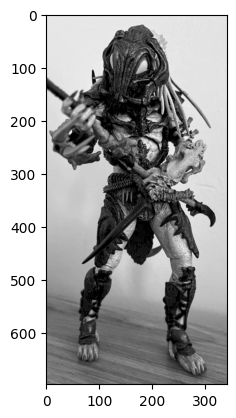

In [111]:
#Levanto la imagen
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
plt.figure()
plt.imshow(img, cmap = 'gray')
plt.show()

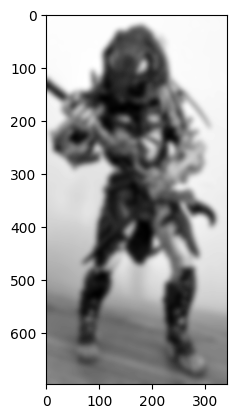

In [112]:
#Aplico filtro gaussiano
img_gauss = cv.filter2D(img, -1, create_gauss_filter(25,25,1,5)[0])
plt.figure()
plt.imshow(img_gauss, cmap = 'gray')
plt.show()

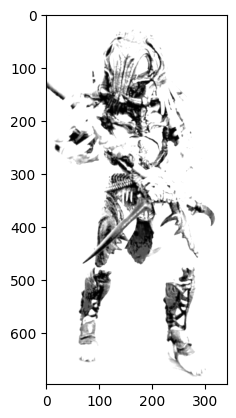

In [113]:
#Aplico filtro gaussiano con fft
img_fft = cv.filter2D(img, -1, create_gauss_filter(25,25,1,5)[1])
plt.figure()
plt.imshow(img_fft, cmap = 'gray')
plt.show()

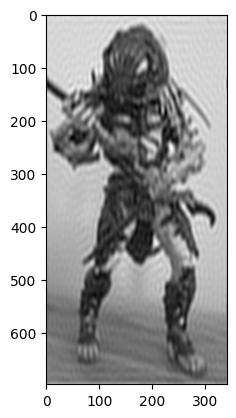

In [114]:
h, w = img.shape
lp_filter = create_lp_filter(h, w, radius=40)

shifted_fft = np.fft.fftshift(np.fft.fft2(img))
lp_filtered = shifted_fft * lp_filter

# Aplicamos la antitransformada y obtenemos las imagenes filtradas
f_ishift = np.fft.ifftshift(lp_filtered)
img_lp = np.real(np.fft.ifft2(f_ishift))

plt.figure()
plt.imshow(img_lp, cmap = 'gray')
plt.show()

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_10380\1916977517.py:5: RuntimeWarning: divide by zero encountered in log
  return 20*np.log(np.abs(shifted_image_fft))


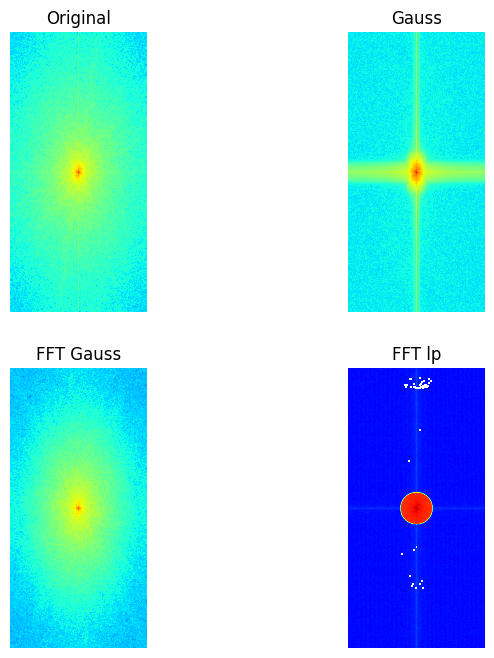

In [115]:
# obtengo el modulo de las transformadas de fourier y grafico
mod = fft2_mod(img)
mod_gauss = fft2_mod(img_gauss)
mod_fft = fft2_mod(img_fft)
mod_lp = fft2_mod(img_lp)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.title('Original')
plt.axis('off')
plt.imshow(mod, cmap='jet')

plt.subplot(2,2,2)
plt.title('Gauss')
plt.axis('off')
plt.imshow(mod_gauss, cmap='jet')

plt.subplot(2,2,3)
plt.title('FFT Gauss')
plt.axis('off')
plt.imshow(mod_fft, cmap='jet')

plt.subplot(2,2,4)
plt.title('FFT lp')
plt.axis('off')
plt.imshow(mod_lp, cmap='jet')

In [116]:
#Algoritmo de calidad de imagen
def img_quality_measure(input_img:np.ndarray):
    img_size = input_img.shape
    f = np.fft.fft2(input_img)
    fc = np.fft.fftshift(f)
    #af = 20*np.log(np.abs(fc))
    af = np.abs(fc)
    m = np.max(af)
    thresh = m / 1000
    th = np.count_nonzero(f > thresh)
    fm = th/(img_size[0] * img_size[1])

    return fm

In [117]:
print(img_quality_measure(img))
print(img_quality_measure(img_gauss))
print(img_quality_measure(img_fft))
print(img_quality_measure(img_lp))

0.010263929618768328
0.002289742792561907
0.006751590215866027
0.006121385777546236


In [132]:
#Brenner’s focus measure (MIS2)
def brenner_focus_measure(input_img:np.ndarray):
    h, w = input_img.shape
    ret_val = 0
    for index, item in np.ndenumerate(input_img):
        if index[0] < w - 2:
            ret_val = ret_val + (input_img[index[0], index[1]] - input_img[index[0] + 2, index[1]]) ** 2
    return ret_val


In [133]:
print(brenner_focus_measure(img))
print(brenner_focus_measure(img_gauss))
print(brenner_focus_measure(img_fft))
print(brenner_focus_measure(img_lp))

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_10380\3301029497.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  ret_val = ret_val + (input_img[index[0], index[1]] - input_img[index[0] + 2, index[1]]) ** 2


2010992276
1792613746
698018092
933342806513.4028


In [153]:
import random
#Local binary patterns-based measure (MIS6)
def lbp_measure(input_img:np.ndarray):
    h, w = input_img.shape
    r = 2
    n = 8
    ret_val = 0
    for index, item in np.ndenumerate(input_img):
        if (index[0] > r and index[0] < h - r) or (index[1] > r and index[1] < w - r):
            aux_sum = 0
            for i in range(n):
                x = random.randint(0, r)
                y = random.randint(0, r)
                if(input_img[index[0], index[1]] <= input_img[x,y]):
                    aux_sum = aux_sum + 1 
            ret_val = ret_val + aux_sum
    return ret_val

In [154]:
print(lbp_measure(img))
print(lbp_measure(img_gauss))
print(lbp_measure(img_fft))
print(lbp_measure(img_lp))

1884152
1902808
1903944
1288111
